In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-15 16:41:12.568358: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)
ds_path = "/drive0-storage/Gracia/Dataset/dataset_2"

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 16:41:15.218598: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:41:16.027288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 14112 files belonging to 3 classes.
Using 11290 files for training.
Found 14112 files belonging to 3 classes.
Using 2822 files for validation.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 239.986
(184, 216, 3)


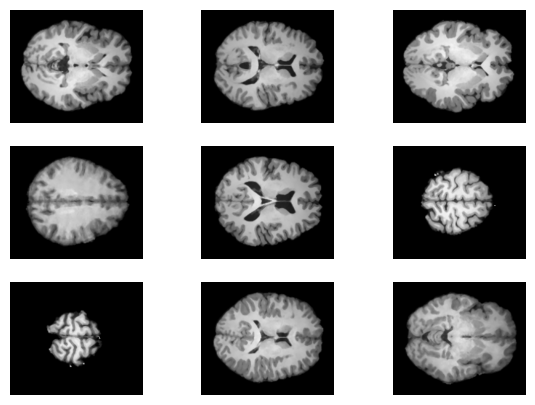

In [6]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [6]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [7]:
print(len(validation_dataset))
print(len(test_dataset))

45
44


## Model building

In [8]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [9]:
with tf.device("GPU"):
    model = build_vgg16()
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [10]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn2_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [11]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-15 16:41:35.494706: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-15 16:41:36.473310: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


353/353 [==============================] - 23s 54ms/step - loss: 1.1038 - accuracy: 0.3436 - val_loss: 1.0992 - val_accuracy: 0.3175
Epoch 2/30
353/353 [==============================] - 19s 52ms/step - loss: 1.0972 - accuracy: 0.3478 - val_loss: 1.0956 - val_accuracy: 0.3550
Epoch 3/30
353/353 [==============================] - 18s 52ms/step - loss: 1.0874 - accuracy: 0.3855 - val_loss: 1.0688 - val_accuracy: 0.4123
Epoch 4/30
353/353 [==============================] - 18s 52ms/step - loss: 1.0347 - accuracy: 0.4516 - val_loss: 0.9965 - val_accuracy: 0.5014
Epoch 5/30
353/353 [==============================] - 18s 52ms/step - loss: 0.9354 - accuracy: 0.5353 - val_loss: 0.9313 - val_accuracy: 0.5134
Epoch 6/30
353/353 [==============================] - 18s 52ms/step - loss: 0.7875 - accuracy: 0.6250 - val_loss: 0.7902 - val_accuracy: 0.6400
Epoch 7/30
353/353 [==============================] - 18s 52ms/step - loss: 0.6153 - accuracy: 0.7332 - val_loss: 0.6401 - val_accuracy: 0.7341
Epo

In [21]:
model.save('./models_retrain/cnn2_16epoch.h5')

### Training evaluation

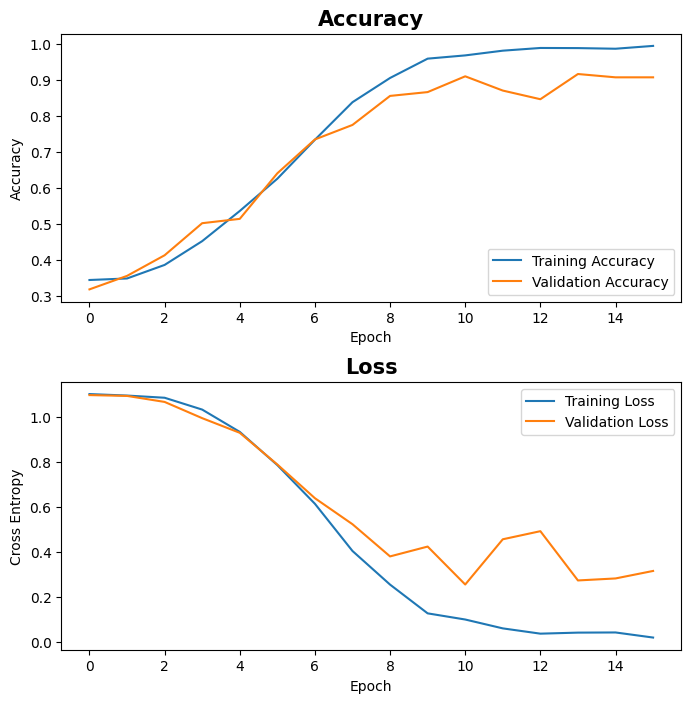

In [12]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')

plt.subplots_adjust(hspace=0.3)
plt.show()

In [13]:
acc

[0.34357839822769165,
 0.3478299379348755,
 0.3854738771915436,
 0.45155003666877747,
 0.5353410243988037,
 0.6249778270721436,
 0.7332152128219604,
 0.8375553488731384,
 0.9048715829849243,
 0.9585474133491516,
 0.9675819277763367,
 0.9806908965110779,
 0.988219678401947,
 0.9878653883934021,
 0.9860938787460327,
 0.9939769506454468]

In [14]:
val_acc

[0.31753888726234436,
 0.355021208524704,
 0.4123055040836334,
 0.50141441822052,
 0.513437032699585,
 0.6400282979011536,
 0.7340877056121826,
 0.7743988633155823,
 0.8550212383270264,
 0.8656294345855713,
 0.909476637840271,
 0.8698726892471313,
 0.8458274602890015,
 0.9158415794372559,
 0.906647801399231,
 0.906647801399231]

In [15]:
loss

[1.1037812232971191,
 1.0971845388412476,
 1.0874119997024536,
 1.0346949100494385,
 0.9354196190834045,
 0.7874910831451416,
 0.6152864098548889,
 0.40508586168289185,
 0.2553805708885193,
 0.12739330530166626,
 0.09998399019241333,
 0.060503970831632614,
 0.03699074313044548,
 0.04161152243614197,
 0.0423390232026577,
 0.019675476476550102]

In [16]:
val_loss

[1.0992026329040527,
 1.0955696105957031,
 1.0688090324401855,
 0.9965017437934875,
 0.9313012361526489,
 0.79020756483078,
 0.6401247978210449,
 0.5242588520050049,
 0.38095301389694214,
 0.4247710704803467,
 0.25581324100494385,
 0.4572164714336395,
 0.4932720959186554,
 0.27392682433128357,
 0.2828250527381897,
 0.3162398338317871]

## Testing

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [18]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

44/44 [==============================] - 1s 20ms/step - loss: 0.3238 - accuracy: 0.9027


{'loss': 0.3237926959991455, 'accuracy': 0.9026988744735718}

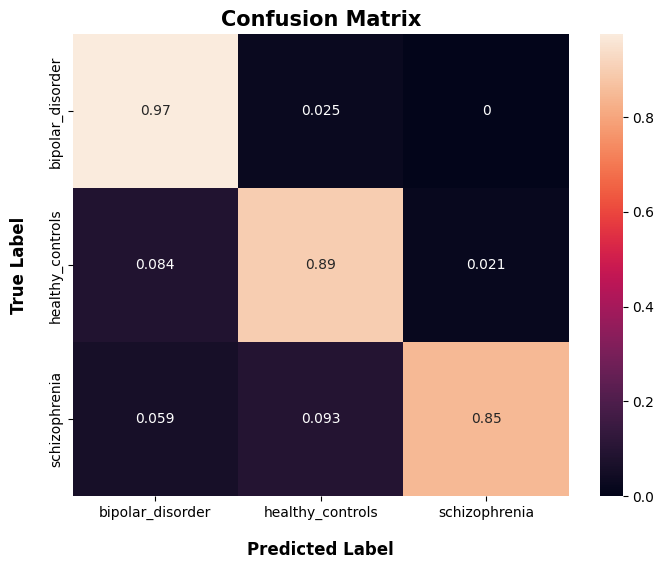

In [19]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN2_cm.png')
plt.show()

In [20]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.9026988744735718
Precision: 0.9105483546401515
Sensitivity: 0.90625
Specificity: 0.9528654917005723
